**Отображатель графиков обучения**

Изменения:

 - Без изменений

In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()

plot = PlotLearning()

**Загрузка и подготовка данных**

Изменения:

 - Без изменений

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


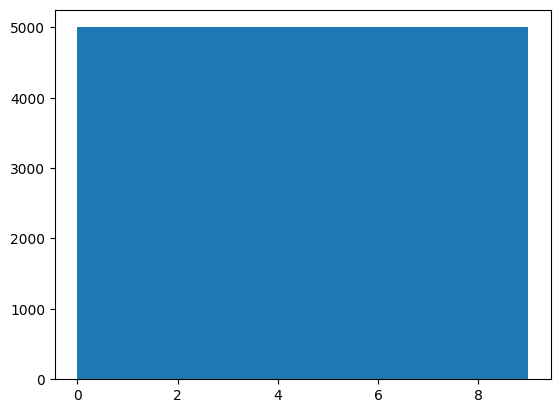

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
import numpy as np

num_classes = 10
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_cnn_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

plt.hist(y_train, num_classes)
plt.show()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

**Нормализация данных**

Изменения:

 - Без изменений, стандартная нормализация значений пикселей

In [3]:
x_train /= 255
x_test /= 255

**Определение ResNet блока**

Изменения:

 - Добавлен параметр dropout_rate для регуляризации

 - Добавлена L2 регуляризация для сверточных слоев

 - Улучшена структура блока с добавлением dropout после каждого сверточного слоя

 - Добавлен параметр kernel_size для гибкости в настройке

In [4]:
import tensorflow as tf
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=(3,3), dropout_rate=0.0):
        super(ResnetIdentityBlock, self).__init__()
        self.filters = filters
        filters1, filters3 = filters

        # First convolution layer
        self.conv2a = tf.keras.layers.Conv2D(filters1, kernel_size, padding='same',
                                           kernel_regularizer=keras.regularizers.l2(1e-4))
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.dropout2a = tf.keras.layers.Dropout(dropout_rate)

        # Second convolution layer
        self.conv2b = tf.keras.layers.Conv2D(filters3, kernel_size, padding='same',
                                           kernel_regularizer=keras.regularizers.l2(1e-4))
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.dropout2b = tf.keras.layers.Dropout(dropout_rate)

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout2a(x, training=training)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = self.dropout2b(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

    def get_config(self):
        config = super(ResnetIdentityBlock, self).get_config()
        config.update({"filters": self.filters})
        return config

**Создание модели**

Изменения:

 - Использована комбинация MaxPooling и AveragePooling

 - Добавлены LeakyReLU вместо ReLU для предотвращения "умирающих нейронов"

 - Уменьшено количество residual блоков (с 5 до 2 в каждом разделе)

 - Добавлена прогрессивно увеличивающаяся регуляризация (Dropout от 0.2 до 0.5)

 - Использован Adam optimizer с настроенными параметрами

 - Добавлены callback'и для динамического изменения learning rate и ранней остановки

In [5]:
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()

model.add(Conv2D(32, (5,5), input_shape=(32,32,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.2))

for i in range(2):
    resnet_block = ResnetIdentityBlock([32, 32], dropout_rate=0.2)
    model.add(resnet_block)

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

for i in range(2):
    resnet_block = ResnetIdentityBlock([64, 64], dropout_rate=0.3)
    model.add(resnet_block)

model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

for i in range(2):
    resnet_block = ResnetIdentityBlock([128, 128], dropout_rate=0.4)
    model.add(resnet_block)

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=regularizers.l2(1e-4)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block           │ (None, 32, 32, 32)     │        18,752 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_1         │ (None, 32, 32, 32)     │        18,752 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_2         │ (None, 16, 16, 64)     │        74,368 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_3         │ (None, 16, 16, 64)     │        74,368 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_4         │ (None, 8, 8, 128)      │       296,192 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_5         │ (None, 8, 8, 128)      │       296,192 │
│ (ResnetIdentityBlock)           │                        │             

 Total params: 2,975,306 (11.35 MB)

 Trainable params: 2,972,554 (11.34 MB)

 Non-trainable params: 2,752 (10.75 KB)

**Обучение модели**

Изменения:

 - Увеличен размер батча до 128

 - Увеличено количество эпох до 50

 - Добавлены callback'и для уменьшения learning rate

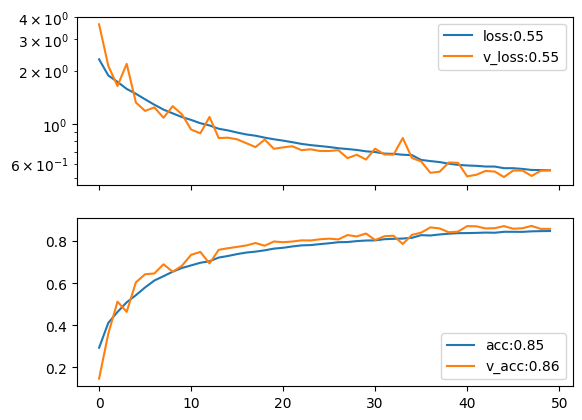


Epoch 50: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8500 - loss: 0.5420 - val_accuracy: 0.8589 - val_loss: 0.5501 - learning_rate: 1.5000e-04


In [6]:
print('Using data augmentation.')
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest')

batch_size = 128
epochs = 50


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[plot, reduce_lr],
          verbose=1)

**Визуализация результатов**

Изменения:

 - Без изменений

          GT class           Predicted class


<ipython-input-7-d7ef7c5af921>:16: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, (4., 4.))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


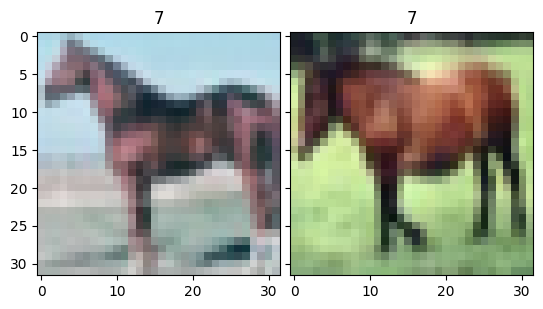

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


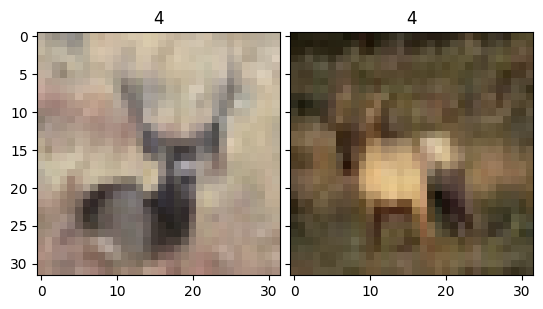

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


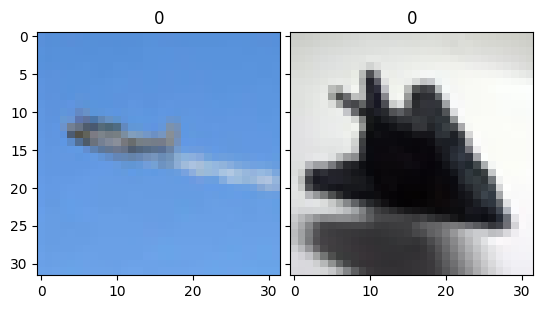

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


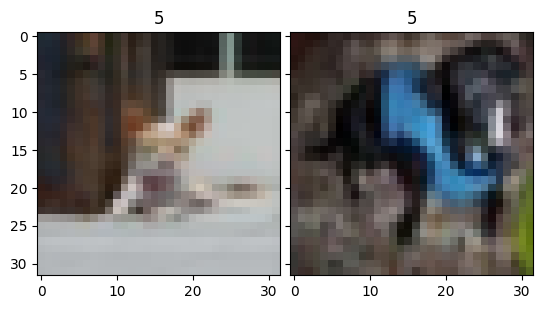

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


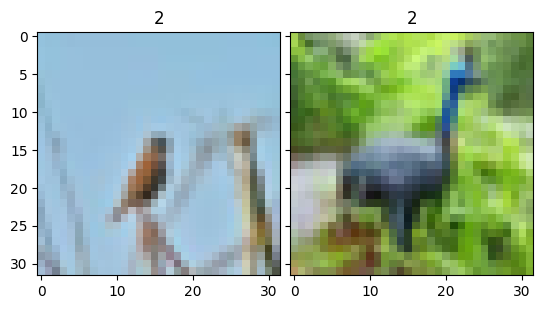

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


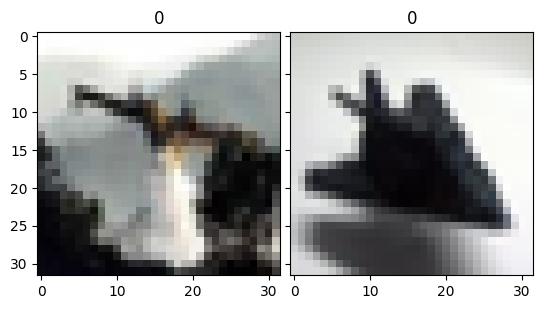

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


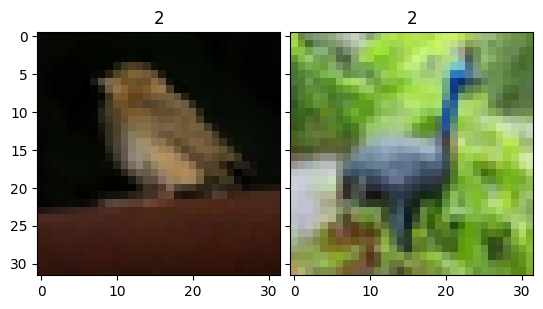

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


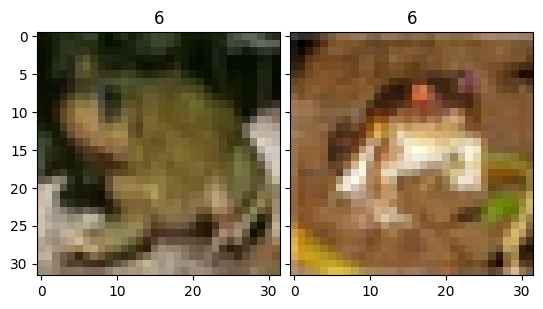

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


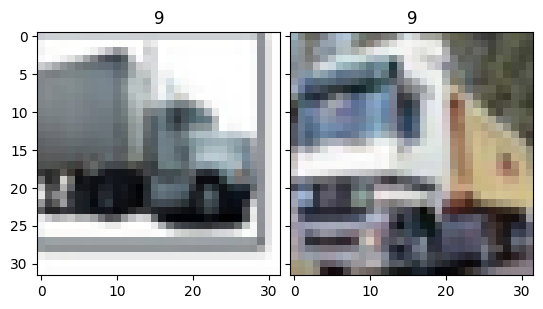

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


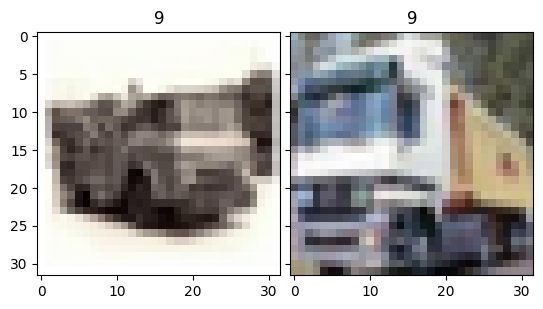

In [7]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(cls_name_pred))

    plt.show()

**Матрица ошибок**

Изменения:

 - Улучшена визуализация матрицы ошибок

 - Добавлены подписи осей

 - Увеличен размер фигуры для лучшей читаемости

 - Ограничено количество тестовых образцов для скорости (1000)

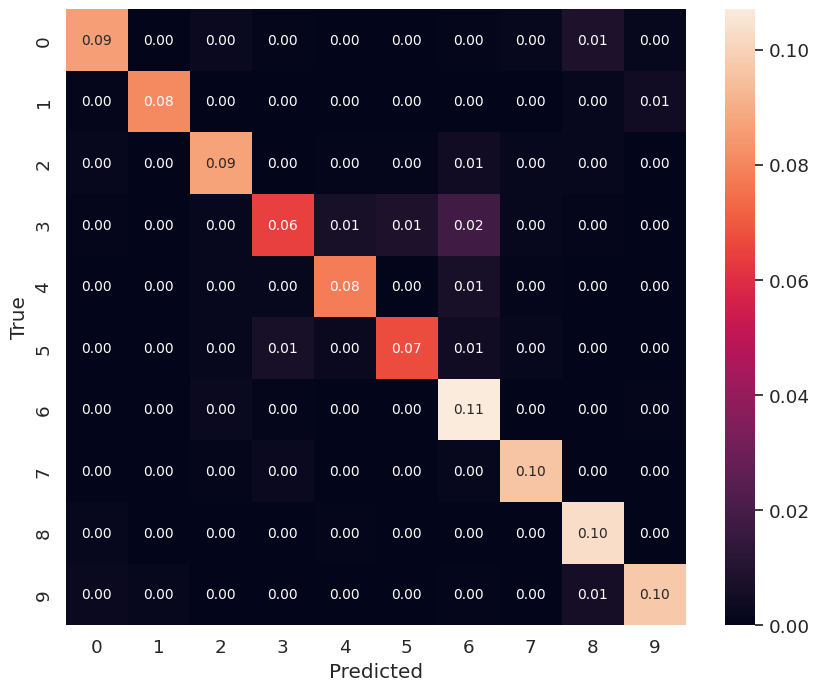

In [8]:
import pandas as pd
import seaborn as sn

def get_conf_matrix(x_test, y_test):
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test[:1000]:  # Using only first 1000 for speed
        yp = np.argmax(model.predict(np.expand_dims(x, axis=0), verbose=0))
        m[np.argmax(y_test[i]),yp] += 1
        i = i+1
    m = m/len(y_test[:1000])

    return m

m = get_conf_matrix(x_test[:1000], y_test[:1000])
df_cm = pd.DataFrame(m, range(10), range(10))
plt.figure(figsize=(10,8))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Классификация изображений**

Изменения:

 - Исправлена обработка цветовых каналов

 - Добавлен вывод предсказанного класса

 - Улучшен вывод информации о предсказании

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
frog.PNG
(2000, 3000, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted probabilities: [[3.29673337e-03 9.99233453e-05 5.79269661e-04 3.59632820e-03
  9.48368688e-04 1.17114156e-04 1.41971586e-02 3.81494647e-05
  9.76837873e-01 2.89061136e-04]]
Predicted class: 8


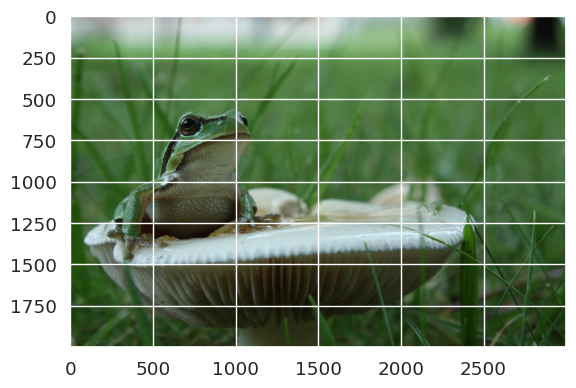

In [11]:
import cv2
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
!ls /content/drive/MyDrive/datasets

img = cv2.imread("/content/drive/MyDrive/datasets/frog.PNG")
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Fixed color channel order
img = cv2.resize(img,(32,32))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))
print("Predicted probabilities:", y)
print("Predicted class:", np.argmax(y))